## Step 1: Import Libraries and Load Your Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

# Optional: Set display options to inspect all data if needed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Load the CSV file (if needed)
df = pd.read_csv("AFG vs SA.csv")

# Drop any unwanted "Unnamed: 0" column if present
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

df.head(2)

,Date,Batting Team,Bowling Team,Striker,Non-Striker,Bowler,Innings,Unique,Over Number,Over Ball,Runs,Wides,Team Runs,Remaining Overs,Lead By,Trail By,Fall Of Wickets,Day,Session,Leg Byes,No Balls,Balls,Byes,Remaining Balls,Remaining Runs,Run Rate,Batter Sixes,Batter Runs,Batter Fours,Batter Balls,Batter Total Runs,Dismissal Type,Dismissal Fielder,On Field Minutes,Shot Angle,Shot Magnitude,Wagon Position,Pitching Length,Pitching Line,Shot Connection,False Shot,Feet Movement,Shot Type,Delivery Type,Bowling Side,Bowling Type,Bowling Hand,Catch Difficulty
0,22-02-2025 14:00,South Africa,Afghanistan,Ryan Rickelton,Tony de Zorzi,Fazalhaq Farooqi,1,0.1,1,1,0,0,0,49.5,0,0,0,1,1,0,0,1,0,299,NaN,0.0,0,0,0,1,0,NaN,NaN,0,254,90,Mid On,Full Toss,Outside Off,Good,0,Front Foot,Flick,InSwinger,Over,Fast,Left,0
1,22-02-2025 14:00,South Africa,Afghanistan,Ryan Rickelton,Tony de Zorzi,Fazalhaq Farooqi,1,0.2,1,2,0,0,0,49.4,0,0,0,1,1,0,0,2,0,298,NaN,0.0,0,0,0,2,0,NaN,NaN,0,270,40,Bowler,Half Volley,Off stump,Good,0,Front Foot,Forward Defensive,InSwinger,Over,Fast,Left,0


## Step 2: Define AFG’s Outcome Probabilities

In [16]:
def get_pbvalues_afg():
    """
    Returns cumulative probability thresholds for AFG batting outcomes.
    Outcomes: 0, 1, 2, 3, 4, 6, and wicket.
    (Placeholder probabilities: adjust based on historical data.)
    """
    # Raw probabilities (example values)
    p_0 = 0.32   # 32% chance for 0 runs
    p_1 = 0.38   # 38% chance for 1 run
    p_2 = 0.05   # 5% chance for 2 runs
    p_3 = 0.02   # 2% chance for 3 runs
    p_4 = 0.10   # 10% chance for 4 runs
    p_6 = 0.08   # 8% chance for 6 runs
    p_w = 0.05   # 5% chance of wicket
    
    # Cumulative thresholds:
    p0 = p_0                         # ≤ 0.32  means 0 runs
    p1 = p0 + p_1                    # ≤ 0.32+0.38 = 0.70 means 1 run
    p2 = p1 + p_2                    # ≤ 0.70+0.05 = 0.75 means 2 runs
    p3 = p2 + p_3                    # ≤ 0.75+0.02 = 0.77 means 3 runs
    p4 = p3 + p_4                    # ≤ 0.77+0.10 = 0.87 means 4 runs
    p6 = p4 + p_6                    # ≤ 0.87+0.08 = 0.95 means 6 runs
    pw = 1.0                         # remaining up to 1.0 means wicket
    
    return p0, p1, p2, p3, p4, p6, pw

# For debugging, print cumulative thresholds:
print("AFG cumulative thresholds:", get_pbvalues_afg())


AFG cumulative thresholds: (0.32, 0.7, 0.75, 0.77, 0.87, 0.95, 1.0)


## Step 3: Simulation of AFG’s Chase

In [17]:
def predict_runs_afg(target, current_score, current_wickets, current_overs):
    """
    Simulate the remainder of AFG's chase using the cumulative probabilities.
    
    Parameters:
      target: The total score AFG must surpass (here, 316).
      current_score: Current runs scored.
      current_wickets: Current wickets lost.
      current_overs: Overs completed (e.g., 19.0 for 19 overs).
      
    Returns:
      Predicted final score (runs).
    """
    # Get cumulative thresholds for AFG batting outcomes
    p0, p1, p2, p3, p4, p6, pw = get_pbvalues_afg()
    
    pred_runs = current_score
    pred_wkts = current_wickets
    
    # Convert current_overs (e.g., 19.0 or 19.2) into total balls bowled.
    overs_int = int(current_overs)
    overs_dec = int(round((current_overs - overs_int) * 10))  # e.g., 19.2 -> 2 balls
    balls_bowled = overs_int * 6 + overs_dec
    
    # Total balls in an ODI = 300 (50 overs)
    leftover_balls = 300 - balls_bowled
    
    for _ in range(leftover_balls):
        if pred_wkts == 10:  # all out
            break
        if pred_runs >= target:  # chase reached or surpassed
            break
        
        r_value = np.random.random()
        
        # Use cumulative probabilities to decide the ball's outcome.
        if r_value <= p0:
            # 0 runs: no change
            pass
        elif r_value <= p1:
            pred_runs += 1
        elif r_value <= p2:
            pred_runs += 2
        elif r_value <= p3:
            pred_runs += 3
        elif r_value <= p4:
            pred_runs += 4
        elif r_value <= p6:
            pred_runs += 6
        else:
            # Wicket falls
            pred_wkts += 1
            
    return pred_runs

# Test a single simulation (starting from AFG's current state: 70/4 in 19 overs, target = 316)
print("Predicted final runs (one simulation):", predict_runs_afg(316, 70, 4, 19))


Predicted final runs (one simulation): 197


## Step 4: Determine Outcome (Win, Tie, Lose)

In [18]:
def get_win_afg(pred_runs, target):
    """
    Returns the outcome of the simulation:
      'win' if pred_runs > target,
      'tie' if pred_runs == target,
      'lose' otherwise.
    """
    if pred_runs > target:
        return 'win'
    elif pred_runs == target:
        return 'tie'
    else:
        return 'lose'

# Test the outcome function:
test_runs = predict_runs_afg(316, 70, 4, 19)
print("Outcome of simulation:", get_win_afg(test_runs, 316))


Outcome of simulation: lose


## Step 5: Find Required Runs at a Given Over

In [19]:
def find_runs_afg(current_score, target, current_wickets, at_overs, sims=100):
    """
    Iterates over hypothetical scores starting from current_score up to target.
    For each score, runs 'sims' simulations and counts wins.
    Returns the first hypothetical score that yields at least 50% wins.
    """
    for hypothetical_score in range(current_score, target + 1):
        win_count = 0
        for _ in range(sims):
            pred = predict_runs_afg(target, hypothetical_score, current_wickets, at_overs)
            if get_win_afg(pred, target) == 'win':
                win_count += 1
        if win_count >= sims * 0.5:
            return hypothetical_score
    return current_score

# Example: Find required runs by 20 overs, given current state of 70/4
print("Required runs by 20 overs:", find_runs_afg(70, 316, 4, 20))


Required runs by 20 overs: 204


## Step 6: Find Allowed Wickets at a Given Over

In [20]:
def find_wickets_afg(current_score, target, current_wickets, at_overs, sims=100):
    """
    Iterates from current_wickets up to 9 and runs 'sims' simulations for each wicket count.
    Returns the maximum number of wickets that can be lost while maintaining at least 50% win probability.
    """
    allowed_wickets = current_wickets
    for w in range(current_wickets, 10):
        win_count = 0
        for _ in range(sims):
            pred = predict_runs_afg(target, current_score, w, at_overs)
            if get_win_afg(pred, target) == 'win':
                win_count += 1
        if win_count < sims * 0.5:
            break
        else:
            allowed_wickets = w
    return allowed_wickets

# Example: Find allowed wickets by 20 overs given current state 70/4
print("Allowed wickets by 20 overs:", find_wickets_afg(70, 316, 4, 20))


Allowed wickets by 20 overs: 4


## Step 7: Create the Interactive Visualization

In [21]:
def find_runs_wickets_afg(current_wks, at_overs, target_score):
    plt.figure(figsize=(10, 5))
    
    # For an interactive model, we can set the starting (current) score.
    # In this match, AFG is currently 70/4 in 19 overs.
    # We use the actual current score if at_overs equals the current over, 
    # but here we allow the user to explore different overs.
    # For simulation, if at_overs equals the current over (19), we could fix current_score = 70.
    # For simplicity, assume current_score = 70 for all cases.
    current_score = 70  

    # Calculate required runs and allowed wickets at the specified over
    req_value = find_runs_afg(current_score, target_score, current_wks, at_overs)
    req_wk_value = find_wickets_afg(current_score, target_score, current_wks, at_overs)
    
    # Special case: if at_overs is 19 (the current state), then required runs/wickets should be the current state.
    if at_overs == 19:
        req_value = current_score
        req_wk_value = current_wks

    # Plot a dashed line for the target score
    plt.axhline(target_score, ls='--', color='red')
    plt.text(1, target_score + 10, f"Target Score: {target_score}", color='darkgreen', fontsize=12)
    
    # Plot the required state as a big red dot
    plt.scatter(at_overs, req_value, s=1000, color='royalblue')
    plt.text(at_overs, req_value, f"{req_value}/{req_wk_value}",
             color='floralwhite', fontsize=12, ha='center', va='center')
    
    plt.text(at_overs, req_value - 30,
             f"AFG should be at {req_value}/{req_wk_value} after {at_overs} ov",
             ha='center')
    
    plt.title("Where should AFG be?", fontsize=16)
    plt.xlabel("Overs")
    plt.ylabel("Score")
    plt.xlim(0, 50)
    plt.ylim(0, target_score + 50)
    plt.show()

# Create the interactive widget:
# Default parameters: current_wks = 4, at_overs = 19 (current state), target_score = 316.
interactive_plot = interactive(
    find_runs_wickets_afg,
    current_wks=IntSlider(min=0, max=9, step=1, value=4),
    at_overs=IntSlider(min=19, max=50, step=1, value=19),
    target_score=IntSlider(min=300, max=350, step=1, value=316)
)
interactive_plot

interactive(children=(IntSlider(value=4, description='current_wks', max=9), IntSlider(value=19, description='a…

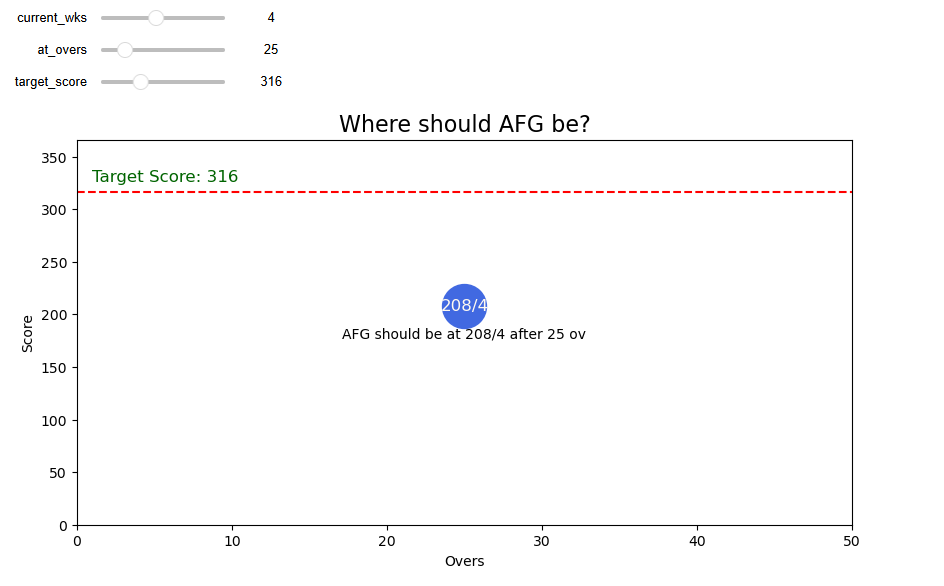